In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import json
import yaml
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
model_yaml_dir='./model_yaml/'
model_h5_dir='./model_h5/'
trainDatasetDir='./datasets/dogs_vs_cats/train/'
TFRecordPath=trainDatasetDir+'train.tfrecords'

os.makedirs(model_yaml_dir) if not os.path.exists(model_yaml_dir) else None   
os.makedirs(model_h5_dir) if not os.path.exists(model_h5_dir) else None

In [3]:
def get_image_path(trainDatasetDir):
    catsTrainDatasetDir=trainDatasetDir+'cats/'
    dogsTrainDatasetDir=trainDatasetDir+'dogs/'

    catsTrainDatasetPath=tf.constant([catsTrainDatasetDir+filename for filename in os.listdir(catsTrainDatasetDir)])
    dogsTrainDatasetPath=tf.constant([dogsTrainDatasetDir+filename for filename in os.listdir(dogsTrainDatasetDir)])
    trainDatasetPath=tf.concat([catsTrainDatasetPath,dogsTrainDatasetPath],axis=-1)

    trainDatasetLabel=tf.concat([tf.zeros(catsTrainDatasetPath.shape,dtype=tf.int32),
                                 tf.ones(dogsTrainDatasetPath.shape,dtype=tf.int32)],
                                 axis=-1)

    return trainDatasetPath, trainDatasetLabel

def decode_resize_image(trainDatasetPath,trainDatasetLabel):
    trainDatasetImage=tf.io.read_file(trainDatasetPath)
    trainDatasetImage=tf.image.decode_jpeg(trainDatasetImage)
    trainDatasetImage=tf.image.resize(trainDatasetImage,[224,224])/255.0
    return trainDatasetImage,trainDatasetLabel

In [4]:
def store_model_parameter(model):
    jsonString=model.to_json()
    yamlString=yaml.dump(json.loads(jsonString))
    with open('./model_yaml/dogs_vs_cats.yaml','w') as modelYaml:
        modelYaml.write(yamlString)
    model.save_weights('./model_h5/dogs_vs_cats.h5')
    print('model structure and weight has been stored separately')
    
def restore_model_parameter():
    with open('./model_yaml/dogs_vs_cats.yaml') as yamlString:
        modelYaml=yamlString.read()
    modelJson=json.dumps(yaml.safe_load(modelYaml))
    restoredModel=tf.keras.models.model_from_json(modelJson)
    restoredModel.load_weights('./model_h5/dogs_vs_cats.h5')
    restoredModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print('model structure and weight has been restored')
    return restoredModel

In [5]:
TFRecordFeature={'image':tf.io.FixedLenFeature([],tf.string),
                 'label':tf.io.FixedLenFeature([],tf.int64)}

def store_TFRecord(trainDatasetDir,TFRecordPath):
    catsTrainDatasetDir=trainDatasetDir+'cats/'
    dogsTrainDatasetDir=trainDatasetDir+'dogs/'

    catsTrainDatasetPath=[catsTrainDatasetDir+filename for filename in os.listdir(catsTrainDatasetDir)]
    dogsTrainDatasetPath=[dogsTrainDatasetDir+filename for filename in os.listdir(dogsTrainDatasetDir)]
    trainDatasetPath=catsTrainDatasetPath+dogsTrainDatasetPath
    trainDatasetLabel=[0]*len(catsTrainDatasetPath)+[1]*len(dogsTrainDatasetPath)

    with tf.io.TFRecordWriter(TFRecordPath) as TFRecordWriter:
        for path,label in zip(trainDatasetPath,trainDatasetLabel):
            imageByteList=open(path,'rb').read()
            TFRecordFeature={'image':tf.train.Feature(bytes_list=tf.train.BytesList(value=[imageByteList])),
                             'label':tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))}
            TFRecordExample=tf.train.Example(features=tf.train.Features(feature=TFRecordFeature))
            TFRecordWriter.write(TFRecordExample.SerializeToString())
    print('TFRecord has been created and stored')

def parse_TFRecord(exampleString):
    featureDict=tf.io.parse_single_example(exampleString,TFRecordFeature)
    featureDict['image']=tf.io.decode_jpeg(featureDict['image'])
    featureDict['image']=tf.image.resize(featureDict['image'],[224,224])/255.0
    return featureDict['image'],featureDict['label']

def restore_TFRecord(TFRecordPath):
    restoredDataset=tf.data.TFRecordDataset(TFRecordPath)
    restoredDataset=restoredDataset.map(parse_TFRecord)
    print('TFRecord has been restored and used')
    return restoredDataset

In [6]:
if not os.path.isfile(TFRecordPath):
    print('TFRecord does not exist, creating for next time use')
    store_TFRecord(trainDatasetDir,TFRecordPath)
    
    trainDatasetPath,trainDatasetLabel=get_image_path(trainDatasetDir)
    dataset=tf.data.Dataset.from_tensor_slices((trainDatasetPath,trainDatasetLabel))
    dataset=dataset.map(map_func=decode_resize_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset=dataset.shuffle(len(dataset))
else:
    print('TFRecord found, restoring for use this time')
    dataset=restore_TFRecord(TFRecordPath)
    dataset=dataset.shuffle(2000)

TFRecord found, restoring for use this time
TFRecord has been restored and used


shape of sample dataset: (224, 224, 3) , shape of sample label: ()


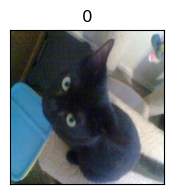

In [7]:
sampleDataset=dataset.take(1)
for sampleFeature,sampleLabel in sampleDataset:
    print('shape of sample dataset:',sampleFeature.shape,', shape of sample label:',sampleLabel.shape)
    plt.figure(figsize=(2,2)) 
    plt.title(sampleLabel.numpy())
    plt.xticks([])
    plt.yticks([])
    plt.imshow(sampleFeature.numpy())
    plt.show()

In [8]:
batchSize=10
dataset=dataset.batch(batchSize)
dataset=dataset.prefetch(tf.data.experimental.AUTOTUNE)

shape of batched dataset: (10, 224, 224, 3) , shape of dataset label: (10,)


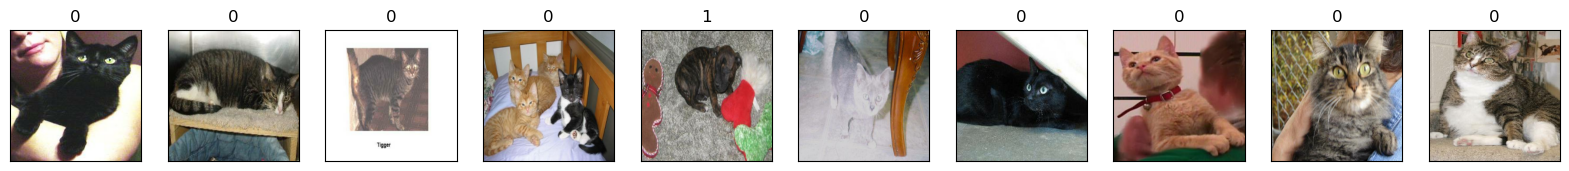

In [9]:
datasetIter=iter(dataset)
feature,label=next(datasetIter)
print('shape of batched dataset:',feature.shape,', shape of dataset label:',label.shape)

fig,axs=plt.subplots(1,batchSize,figsize=(20,2))
for i in range(batchSize):
    axs[i].set_title(label.numpy()[i])
    axs[i].imshow(feature.numpy()[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

In [10]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.950):
            print('\nModel accuracy is enough so training will stop')
            self.model.stop_training=True

callbacks=stop_training_callback()

In [11]:
if os.path.isfile(model_yaml_dir+'dogs_vs_cats.yaml') and os.path.isfile(model_h5_dir+'dogs_vs_cats.h5'):
    print('trained model found, restoring the parameter')
    model=restore_model_parameter()

else:
    print('trained model not found, creating the model')
    vgg16=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))
    [setattr(layer,'trainable',False) for layer in vgg16.layers]

    vgg16OutputLayer=vgg16.output
    newOutputLayer=tf.keras.layers.Flatten()(vgg16OutputLayer)
    newOutputLayer=tf.keras.layers.Dense(128,activation='relu')(newOutputLayer)
    newOutputLayer=tf.keras.layers.Dropout(0.3)(newOutputLayer)
    newOutputLayer=tf.keras.layers.Dense(32,activation='relu')(newOutputLayer)
    newOutputLayer=tf.keras.layers.Dropout(0.3)(newOutputLayer)
    newOutputLayer=tf.keras.layers.Dense(2,activation='softmax')(newOutputLayer)

    model=tf.keras.models.Model(inputs=vgg16.input,outputs=newOutputLayer)
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.fit(dataset,epochs=100,verbose=1,callbacks=[callbacks])
    store_model_parameter(model)

trained model not found, creating the model
Epoch 1/100
200/200 [==============================] - 5s 15ms/step - loss: 0.6625 - accuracy: 0.7160
Epoch 2/100
200/200 [==============================] - 3s 12ms/step - loss: 0.3191 - accuracy: 0.8520
Epoch 3/100
200/200 [==============================] - 3s 12ms/step - loss: 0.2297 - accuracy: 0.8985
Epoch 4/100
200/200 [==============================] - 3s 12ms/step - loss: 0.2079 - accuracy: 0.9195
Epoch 5/100
200/200 [==============================] - 3s 12ms/step - loss: 0.1612 - accuracy: 0.9260
Epoch 6/100
200/200 [==============================] - 3s 12ms/step - loss: 0.1362 - accuracy: 0.9395
Epoch 7/100
200/200 [==============================] - 2s 12ms/step - loss: 0.1159 - accuracy: 0.9475
Epoch 8/100
200/200 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9515
Model accuracy is enough so training will stop
200/200 [==============================] - 3s 12ms/step - loss: 0.1256 - accuracy: 0.9515
model st

In [12]:
def load_test_dataset(testDatasetDir,startIndex,endIndex,imageSize=(224,224)):
    testDataset=[]

    for filename in os.listdir(testDatasetDir)[startIndex:endIndex]:
        testDatasetPath=testDatasetDir+filename
        img=image.load_img(testDatasetPath,target_size=imageSize)
        img=image.img_to_array(img)
        testDataset.append(img)
    testDataset=np.array(testDataset)/255.0

    return testDataset

1/1 [==============================] - 0s 149ms/step


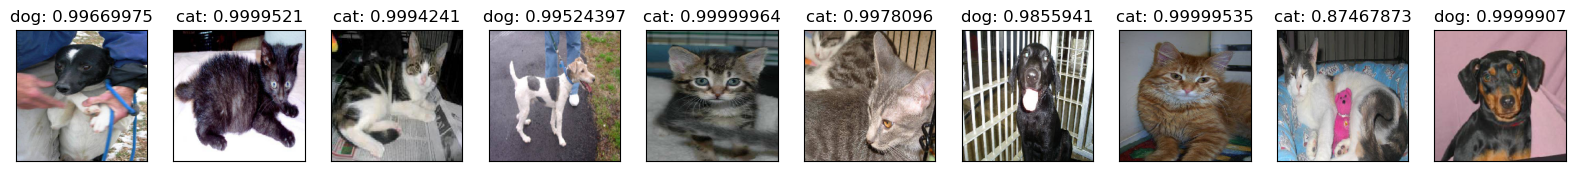

In [13]:
testDatasetDir='./datasets/dogs_vs_cats/test/'
startIndex=0
endIndex=10
testDataset=load_test_dataset(testDatasetDir,startIndex,endIndex)
prediction=model.predict(testDataset)

fig,axs=plt.subplots(1,endIndex-startIndex,figsize=(20,2))
for i in range(0,endIndex-startIndex):
    if np.argmax(prediction[i])==1:
        axs[i].set_title('dog: '+str(prediction[i][1]))
    else:
        axs[i].set_title('cat: '+str(prediction[i][0]))
    axs[i].imshow(testDataset[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()